# <center> REVIEW OF DOCUMENT CLASSIFICATION TECHNIQUES </center>

In [8]:
# IMPORTS
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # register converter for timestamps
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
import re
import string
import nltk
import gensim

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MaxAbsScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## I. DATA PREPARATION

In [9]:
# LOAD DATASET
filepath = '../data/Consumer_Complaints.csv' 
df = pd.read_csv(filepath)
print('Shape of the data :', df.shape)
df.head(2)

/Users/Samyer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of the data : (1377383, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,09/06/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"GENERAL MOTORS FINANCIAL COMPANY, INC.",VA,23185,Servicemember,NaN,Web,09/06/2019,Closed with explanation,Yes,NaN,3366091
1,09/06/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,NaN,NaN,Statebridge Company,TN,37087,Older American,NaN,Web,09/06/2019,In progress,Yes,NaN,3365134


**Comment :**

The dataset has over 1M rows, however, not all of them include a `Consumer complaint narrative` which is the text we  care about classifying. Thus we need to remove the unnecessary rows.

In [10]:
# CLEAN DATA
df = df.dropna(subset=['Consumer complaint narrative'])
df['Date received'] = pd.to_datetime(df['Date received'], infer_datetime_format=True)
df = df[['Date received', 'Consumer complaint narrative', 'Product']]
df.set_index('Date received', inplace=True)
df.sort_index(inplace=True)
print('Shape of clean dataset is :', df.shape)

Shape of clean dataset is : (436304, 2)


**Comment :**

From reading about the dataset on the source website, I realized that at some point, the number of categories (complaint product) changed : some classes were merged together, while others dissociated into multiple ones. This is problematic and needs to be taken care of. Let us inspect that in more details.

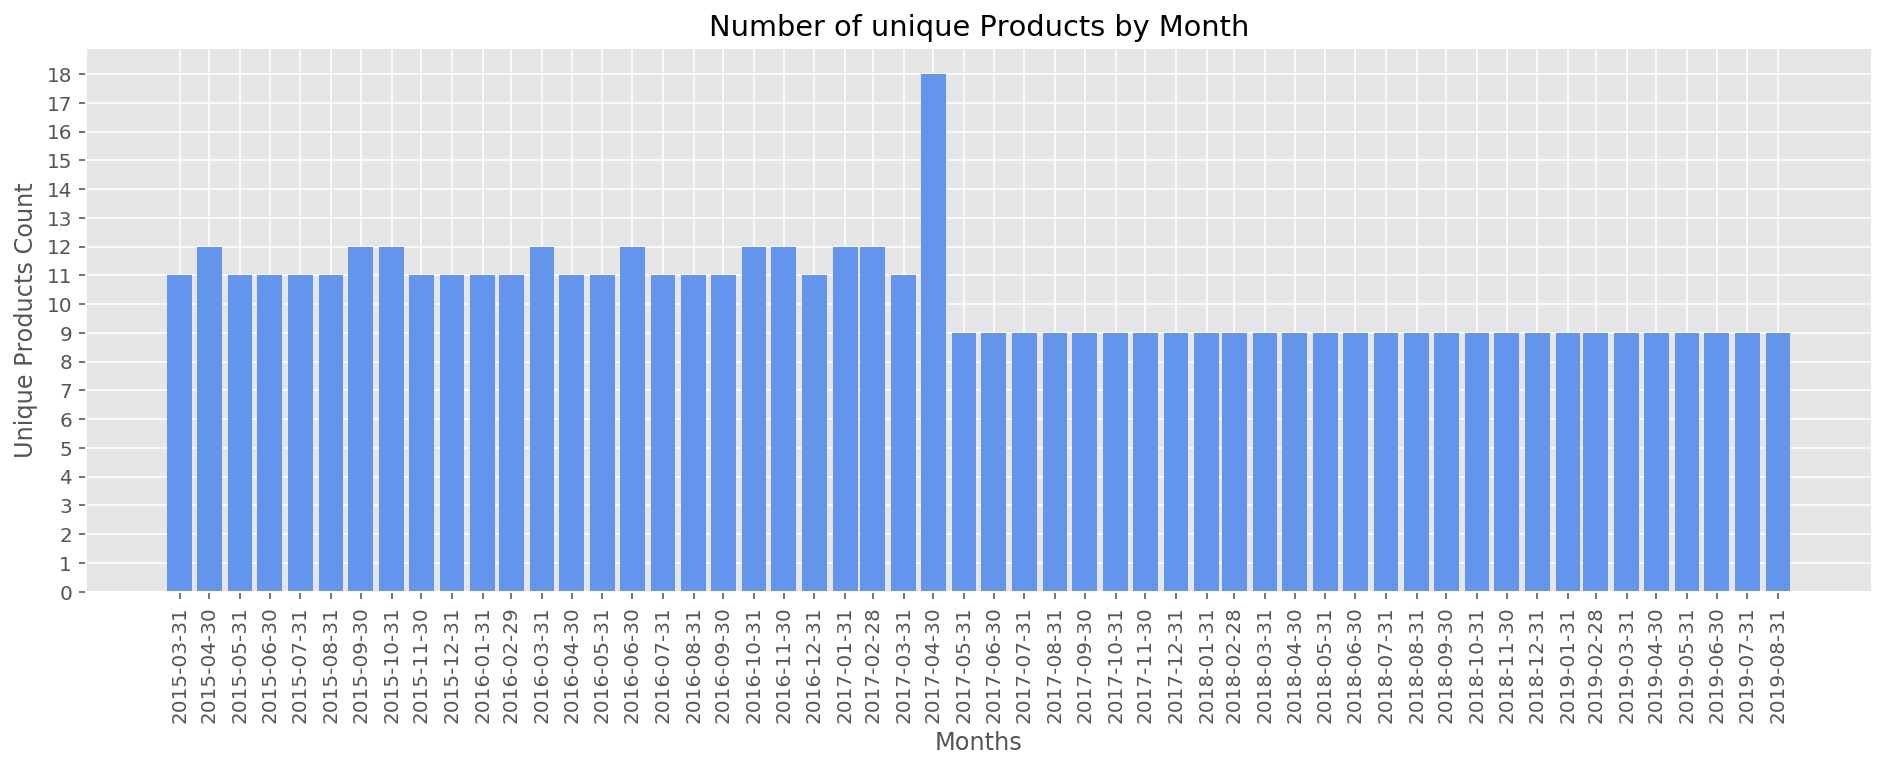

In [15]:
# EVOLUTION OF NUMBER OF CLASSES
nb_products  = df.resample('M')['Product'].agg(lambda x: len(np.unique(x)))
plt.figure(figsize=(16,5))
plt.bar(nb_products.index, nb_products, width=25, color='cornflowerblue')
plt.xticks(ticks=nb_products.index, labels=nb_products.index.strftime('%Y-%m-%d'), rotation=90)
plt.yticks(ticks=range(0,19))
plt.xlabel('Months')
plt.ylabel('Unique Products Count')
plt.title('Number of unique Products by Month');

**Comment :**

As we can see on the figure above, the number of classes changed during the month of April 2017, moving from the initial 12 classes to 18 different classes, before decreasing back to 9 afterwards. So the number of new classes is 9, and the 18 on April 2017 are basically the union of the 12 and 9 categories before and after the change.

One way to deal with this issue, would be to read what the changes actually are, and standardize the classes throughout the whole period. For example, if the classes $C_{1}$ and $C_{2}$ were merged into a class $C$, we could transform both $C_{1}$ and $C_{2}$ into $C$ before the change. However, I opted for a simpler approach by filtering out all the data before the change. This is acceptable because I would still have enough data left to train my models (roughly 250k rows) while keeping the computations manageable (especially for neural networks).

In [0]:
# SAMPLE DATA
df = df['2017-05-01':]
print('Shape of final sample :', df.shape)

Shape of final sample : (269569, 2)


In [0]:
# EXPORT SAMPLE TO DISK
#df.to_csv('Data/Consumer_Complaints_Sample.csv')

Now that we are done preparing our text data, we can move to exploring the different approaches to text classification. The idea here is not to compare different classification algorithms on the same task, but to explore different problem representations and text classification methodologies.

## II. APPROACH 1 : BAG OF WORDS

In [0]:
# PRE-PROCESS TEXT
text = df['Consumer complaint narrative']
    # REMOVE PUNCTUATION
text = text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    # LOWERCASE
text = text.apply(lambda x: x.lower())
    # REMOVE XXXXXs
text = text.apply(lambda x: re.sub('[Xx]+', '', x))
    # REMOVE STOPWORDS & NUMBERS AND PERFORM STEMMING
stopwords = nltk.corpus.stopwords.words('english')
snow = nltk.stem.SnowballStemmer('english')
text = text.apply(lambda x: ' '.join([snow.stem(word) for word in x.split() if word not in (stopwords) and word.isalpha()]))

In [0]:
# LABEL ENCODING
le = LabelEncoder()
labels = le.fit_transform(df['Product'])

In [0]:
# SPLIT DATA INTO TRAIN-TEST
text_train, text_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=10, 
                                                          shuffle=True, stratify=labels)

In [0]:
# BUILD TERM-DOCUMENT MATRIX
VOCAB_SIZE = 10000
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,3), max_features=VOCAB_SIZE)
X_train = vectorizer.fit_transform(text_train)
X_test = vectorizer.transform(text_test)

In [0]:
# FEATURE SELECTION
N_FEATURES = 3000
ch2 = SelectKBest(chi2, k=N_FEATURES)
X_train_fs = ch2.fit_transform(X_train, y_train)
X_test_fs = ch2.transform(X_test)

In [0]:
# FEATURE SCALING
scaler = MaxAbsScaler()
X_train_fs = scaler.fit_transform(X_train_fs)
X_test_fs = scaler.transform(X_test_fs)

In [0]:
# BUILD ML MODEL
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=150)
lr.fit(X_train_fs, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# TEST ML MODEL
y_pred = lr.predict(X_test_fs)
print('Accuracy of Logistic Regression model : {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))

Accuracy of Logistic Regression model : 84.33%


## III. APPROACH 2 : WORD EMBEDDINGS

In [0]:
# TEXT PROCESSING FOR WORD2VEC
text_wv = df['Consumer complaint narrative']
    # LOWERCASE
text_wv = text_wv.apply(lambda x: x.lower())
    # REMOVE XXXXXs
text_wv = text_wv.apply(lambda x: re.sub('[Xx]+', '', x))
    # REMOVE STOPWORDS & NUMBERS AND PERFORM LEMMATIZATION
stopwords = nltk.corpus.stopwords.words('english')
lem = nltk.stem.WordNetLemmatizer()
text_wv = text_wv.apply(lambda x: ' '.join([lem.lemmatize(word) for word in x.split() if word not in (stopwords) and not word.isdigit()]))

In [0]:
# SPLIT DATA INTO TRAIN-TEST
text_train, text_test, y_train, y_test = train_test_split(text_wv, labels, test_size=0.2, random_state=10, 
                                                          shuffle=True, stratify=labels)

In [0]:
# GROUP DOCUMENTS INTO ONE CORPUS AND TOKENIZE SENTENCES
corpus_wv = '. '.join(text_train)
corpus_wv = re.sub('[.]+', '.', corpus_wv)
sents = nltk.sent_tokenize(corpus_wv)
sents = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in sents]
sents_words = [nltk.word_tokenize(sentence) for sentence in sents]

In [0]:
# TRAIN WORD2VEC SKIP-GRAM (FastText VERSION)
EMBED_DIM = 100
w2v = gensim.models.FastText(sentences=sents_words, min_count=10, size=EMBED_DIM, window=5, sg=1, negative=10, workers=8)

In [0]:
# PRINT SUMMARY
print('Word2Vec vocabulary size is :', len(w2v.wv.vocab))
w2v.wv.most_similar('account', topn=10)

Word2Vec vocabulary size is : 18720


[('acccount', 0.8625718951225281),
 ('accountthe', 0.8291419148445129),
 ('accoun', 0.8250317573547363),
 ('accountshe', 0.8095595836639404),
 ('1account', 0.801620602607727),
 ('accoutn', 0.798793375492096),
 ('accountno', 0.79674232006073),
 ('ccount', 0.7850020527839661),
 ('accout', 0.7811952829360962),
 ('accountthey', 0.776400089263916)]

In [0]:
# SAVE WORD2VEC MODEL
#w2v.save('Models/word2vec.model') # This is the whole neural network, useful if we want to resume training later
#w2v.wv.save('Models/word_vectors.kv') # This is just the word vectors from the trained neural network

### 1.  Word Embeddings paired with Document Quantization

In [0]:
# LOAD WORD EMBEDDINGS
wv = gensim.models.KeyedVectors.load('Models/word_vectors.kv')
print('Shape of word vectors matrix', wv.vectors.shape)
wv['bank']

Shape of word vectors matrix (18720, 100)


array([ 0.0466886 , -0.28114358,  0.18822767, -0.22930813,  0.11218674,
       -0.07249404, -0.22254103,  0.28002495, -0.25690317,  0.3931918 ,
       -0.21720538,  0.20368142,  0.23626675, -0.11263606, -0.07089174,
        0.10087981,  0.08050175,  0.04144349,  0.20350055, -0.24435505,
        0.24461204,  0.22782756, -0.08341325,  0.15069987, -0.01742627,
        0.0066676 ,  0.17441271, -0.12875973,  0.24420668,  0.1532279 ,
       -0.09599497, -0.24601173,  0.2027257 ,  0.46466815,  0.12538399,
       -0.07590363,  0.11164078,  0.18661354, -0.02103791, -0.13141087,
       -0.074992  , -0.01910023,  0.04943294,  0.03032103,  0.26093972,
       -0.5090255 , -0.06854853, -0.06687   ,  0.00880607, -0.24834394,
        0.08548374, -0.34308064,  0.02853707, -0.18564367, -0.26765534,
       -0.3478079 ,  0.0590839 ,  0.23284322,  0.4532712 ,  0.00329465,
        0.05635824,  0.4239933 , -0.10772438,  0.01937741,  0.06718241,
       -0.07894652, -0.22808485, -0.27687338,  0.15638258,  0.02

In [0]:
# CLUSTERING WORDS VIA K-MEANS
K = 1000
kmeans = KMeans(n_clusters=K, n_jobs=-1)
kmeans.fit(wv.vectors)
print('Shape of K-means cluster centroids', kmeans.cluster_centers_.shape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1000, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Shape of K-means cluster centroids (1000, 100)


In [0]:
# WORD CLUSTER MAP
wv_labels = kmeans.predict(wv.vectors)
WORD_CLUSTER_MAP = dict(zip(wv.index2word, wv_labels))
DEFAULT_CLUSTER = K

In [0]:
# DEFINE FUNCTION TO QUANTIZE DOCUMENTS
def quantize(document, n_features):
    vec = np.zeros(n_features,)
    words = nltk.word_tokenize(document)
    for word in words:
        vec[WORD_CLUSTER_MAP.get(word, DEFAULT_CLUSTER)] += 1
    return vec

# DEFINE FUNCTION TO BUILD DATASET
def build_data(texts, n_features):
    data = np.zeros((len(texts), n_features))
    for ix, doc in enumerate(texts):
        if ix % 1000 == 0:
            print('Iteration', ix+1)
        data[ix, :] = quantize(doc, n_features)
    return data

In [0]:
# PREPROCESS TEXT
text_train = text_train.apply(lambda doc: doc.translate(str.maketrans('', '', string.punctuation)))
text_test = text_test.apply(lambda doc: doc.translate(str.maketrans('', '', string.punctuation)))

In [0]:
# CREATE DATASET
X_train = build_data(text_train, K+1)
X_test = build_data(text_test, K+1)

Iteration 1
Iteration 1001
Iteration 2001
Iteration 3001
Iteration 4001
Iteration 5001
Iteration 6001
Iteration 7001
Iteration 8001
Iteration 9001
Iteration 10001
Iteration 11001
Iteration 12001
Iteration 13001
Iteration 14001
Iteration 15001
Iteration 16001
Iteration 17001
Iteration 18001
Iteration 19001
Iteration 20001
Iteration 21001
Iteration 22001
Iteration 23001
Iteration 24001
Iteration 25001
Iteration 26001
Iteration 27001
Iteration 28001
Iteration 29001
Iteration 30001
Iteration 31001
Iteration 32001
Iteration 33001
Iteration 34001
Iteration 35001
Iteration 36001
Iteration 37001
Iteration 38001
Iteration 39001
Iteration 40001
Iteration 41001
Iteration 42001
Iteration 43001
Iteration 44001
Iteration 45001
Iteration 46001
Iteration 47001
Iteration 48001
Iteration 49001
Iteration 50001
Iteration 51001
Iteration 52001
Iteration 53001
Iteration 54001
Iteration 55001
Iteration 56001
Iteration 57001
Iteration 58001
Iteration 59001
Iteration 60001
Iteration 61001
Iteration 62001
Itera

In [0]:
# FEATURE SCALING
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
# BUILD ML MODEL
lr_wv = LogisticRegression(penalty='l1', solver='liblinear', max_iter=150, multi_class='auto')
lr_wv.fit(X_train, y_train)

In [0]:
# TEST ML MODEL
y_pred = lr_wv.predict(X_test)
print('Accuracy of Logistic Regression model : {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))

Accuracy of Logistic Regression model : 81.21%


In [0]:
# TEST ML MODEL
y_pred = lr_wv.predict(X_test)
print('Accuracy of Logistic Regression model : {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))

### 2.  Word Embeddings paired with Neural Networks (NN)

In [0]:
# LOAD WORD EMBEDDINGS
wv = gensim.models.KeyedVectors.load('Models/word_vectors.kv')
print('Shape of word vectors matrix', wv.vectors.shape)
wv['bank']

Shape of word vectors matrix (18720, 100)


array([ 0.0466886 , -0.28114358,  0.18822767, -0.22930813,  0.11218674,
       -0.07249404, -0.22254103,  0.28002495, -0.25690317,  0.3931918 ,
       -0.21720538,  0.20368142,  0.23626675, -0.11263606, -0.07089174,
        0.10087981,  0.08050175,  0.04144349,  0.20350055, -0.24435505,
        0.24461204,  0.22782756, -0.08341325,  0.15069987, -0.01742627,
        0.0066676 ,  0.17441271, -0.12875973,  0.24420668,  0.1532279 ,
       -0.09599497, -0.24601173,  0.2027257 ,  0.46466815,  0.12538399,
       -0.07590363,  0.11164078,  0.18661354, -0.02103791, -0.13141087,
       -0.074992  , -0.01910023,  0.04943294,  0.03032103,  0.26093972,
       -0.5090255 , -0.06854853, -0.06687   ,  0.00880607, -0.24834394,
        0.08548374, -0.34308064,  0.02853707, -0.18564367, -0.26765534,
       -0.3478079 ,  0.0590839 ,  0.23284322,  0.4532712 ,  0.00329465,
        0.05635824,  0.4239933 , -0.10772438,  0.01937741,  0.06718241,
       -0.07894652, -0.22808485, -0.27687338,  0.15638258,  0.02

In [0]:
# TOKENIZE TEXT INTO SEQUENCES OF INTEGERS AND PAD THEM
VOCAB_SIZE = 10000
MAX_LEN = 80
    # Build and Fit Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
    # Tokenize Train and Test Texts
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)
    # Pad Sequences
X_train = pad_sequences(seq_train, maxlen=MAX_LEN, truncating='post')
X_test = pad_sequences(seq_test, maxlen=MAX_LEN, truncating='post')
    # One-Hot-Encode Labels for the Neural Net
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [0]:
# BUILD EMBEDDINGS MATRIX
EMBED_DIM = 100
embeddings_index = dict(zip(wv.index2word, wv.vectors))
embeddings_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))

for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word, None)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

In [0]:
# BUILD MODEL
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.5))
#model.add(Flatten())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))
# POPULATE AND FREEZE EMBEDDING LAYER
model.layers[0].set_weights([embeddings_matrix])
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 76, 64)            32064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 21, 64)            20544     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 585       
Total params: 1,086,217
Trainable params: 86,217
Non-trainable params: 1,000,000
_____________________________________________________________

In [0]:
# COMPILE AND FIT MODEL
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
checkpoint = ModelCheckpoint("Models/nn_pretrained_wv.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train_ohe, epochs=10, batch_size=64, validation_split=0.15, callbacks=[checkpoint])
#model.save_weights('Models/nn_pretrained_wv.h5')


Train on 183306 samples, validate on 32349 samples
Epoch 1/10
183306/183306 [==============================] - 131s 713us/step - loss: 0.6691 - acc: 0.7783 - val_loss: 0.5419 - val_acc: 0.8187

Epoch 00001: val_acc improved from -inf to 0.81870, saving model to Models/nn_pretrained_wv.h5
Epoch 2/10
183306/183306 [==============================] - 139s 758us/step - loss: 0.5211 - acc: 0.8273 - val_loss: 0.4931 - val_acc: 0.8350

Epoch 00002: val_acc improved from 0.81870 to 0.83499, saving model to Models/nn_pretrained_wv.h5
Epoch 3/10
183306/183306 [==============================] - 132s 718us/step - loss: 0.4870 - acc: 0.8367 - val_loss: 0.4787 - val_acc: 0.8388

Epoch 00003: val_acc improved from 0.83499 to 0.83876, saving model to Models/nn_pretrained_wv.h5
Epoch 4/10
183306/183306 [==============================] - 133s 725us/step - loss: 0.4642 - acc: 0.8437 - val_loss: 0.4764 - val_acc: 0.8413

Epoch 00004: val_acc improved from 0.83876 to 0.84126, saving model to Models/nn_pretr

In [0]:
# TEST NEURAL NET MODEL
y_pred = model.predict_classes(X_test)
print('Accuracy of Neural Network model : {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))

Accuracy of Neural Network model : 84.18%


## IV.  APPROACH 3 : TRANSFER LEARNING FROM A PRE-TRAINED LANGUAGE MODEL

In [16]:
# MOUNT GOOGLE DRIVE ACCOUNT
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# CREATE DATA FOLDER
!mkdir data

# COPY DATASET.ZIP FROM DRIVE INTO COLAB
%cp /content/drive/My\ Drive/Datasets/consumer-complaints/Consumer_Complaints_Sample.csv.zip /content/data/.

In [0]:
# UNZIP DATA
import os
import zipfile

local_zip = '/content/data/Consumer_Complaints_Sample.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [21]:
# LOAD DATA SAMPLE
df = pd.read_csv('/content/data/Consumer_Complaints_Sample.csv')
df.head()

,Date received,Consumer complaint narrative,Product
0,2017-05-01,I had a Citibank XXXX XXXX credit card. Af...,Credit card or prepaid card
1,2017-05-01,I am writing to dispute a situation with XXXX...,"Credit reporting, credit repair services, or o..."
2,2017-05-01,last year I filed a complaint about this debts...,Debt collection
3,2017-05-01,I called the XXXX XXXX 2017 to ask a que...,Student loan
4,2017-05-01,XXXX XXXX I moved into a new house in a dif...,Debt collection


In [26]:
# INSTALL BERT-TENSORFLOW (Doesn't work with TF 2.0)
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 3.3MB/s 


In [3]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from bert import run_classifier
from bert import optimization
from bert import tokenization
import bert
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K


# INITIALIZE SESSION
#sess = tf.compat.v1.Session() # For TF 2.0
sess = tf.Session()

# BERT PATH AND MAX SEQUENCE LENGTH
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 256

In [0]:
# TRAIN-TEST SPLIT
train, test = train_test_split(df[['Consumer complaint narrative', 'Product']], test_size=0.2, random_state=10, shuffle=True, stratify= df['Product'])

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['Consumer complaint narrative'], 
                                                                   text_b = None, 
                                                                   label = x['Product']), axis = 1)

test_InputExamples = test.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x['Consumer complaint narrative'], 
                                                                   text_b = None, 
                                                                   label = x['Product']), axis = 1)

In [42]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""  
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"], tokenization_info["do_lower_case"]])

    return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [48]:
# TOKENIZE AN EXAMPLE SENTENCE
tokenizer.tokenize('Sam va a lecole pour fuck')

['sam', 'va', 'a', 'le', '##col', '##e', 'pour', 'fuck']

In [0]:
# CONVERT TRAIN/TEST InputExamples TO FEATURES THAT BERT UNDERSTANDS
label_list = df['Product'].unique().tolist()
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [0]:
# RE-STRUCTURE FEATURES INTO [INPUT_IDS, INPUT_MASKS, SEGMENT_IDS, LABELS]
train_input_ids, train_input_masks, train_segment_ids, train_labels = list(zip(*[(f.input_ids, f.input_mask, f.segment_ids, f.label_id) for f in train_features]))
test_input_ids, test_input_masks, test_segment_ids, test_labels = list(zip(*[(f.input_ids, f.input_mask, f.segment_ids, f.label_id) for f in test_features]))

In [0]:
# ONE-HOT ENCODE LABELS
train_labels_ohe = to_categorical(train_labels)
test_labels_ohe = to_categorical(test_labels)

In [5]:
# CREATE THE BERT LAYER CLASS
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, pooling="first", bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name and not "/pooler/" in var.name]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [6]:
# FUNCTION TO BUILD THE MODEL
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    dense = tf.keras.layers.Dense(128, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(9, activation='softmax')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=2e-5), metrics=['accuracy'])
    model.summary()
    
    return model

# FUNCTION TO INSTANTIATE VARIABLES
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [93]:
# BUILD THE MODEL
model = build_model(MAX_SEQ_LENGTH)

# INSTANTIATE VARIABLES
initialize_vars(sess)

# TRAIN THE MODEL (IT TAKES A LONG TIME, EVEN ON GPU !)
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    to_categorical(train_labels),
    epochs=1,
    batch_size=32
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
# SAVE THE WEIGHTS OF THE MODEL
model.save_weights('../models/bert_weights.h5')

In [103]:
# RELOAD THE MODEL FROM THE SAVED WEIGHTS
mdl = None
mdl = build_model(MAX_SEQ_LENGTH)
initialize_vars(sess)
mdl.load_weights('bert_weights.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [122]:
# EVALUATE THE MODEL
model.evaluate(x=[test_input_ids, test_input_masks, test_segment_ids], y=to_categorical(test_labels))

53914/53914 [==============================] - 1759s 33ms/sample - loss: 0.4241 - acc: 0.8552


[0.4241477071776802, 0.85517675]